# Generative AI Fine Tune
Autor: Morariu Tudor

In [1]:
# !pip install -qq diffusers datasets accelerate wandb open-clip-torch

## Pas 1: Autentificare HuggingFace

In [3]:
from huggingface_hub import notebook_login
notebook_login()

## Pas 2: Import-uri

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

## Pas 3: Incarcarea Dataset-ului

In [5]:
dataset_name = "huggan/smithsonian_butterflies_subset"

# Voi folosi libraria datasets pentru incarcarea datelor
dataset = load_dataset(dataset_name, split="train")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


In [6]:
print(dataset)

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})


### Pas 3.1: Transformarea Dataset-ului

In [7]:
image_size = 256 # Dimensiunea la care resize imaginea
batch_size = 4   # Dimensiunea fiecarui batch

transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)), # Transform-ul de resize al imaginii
        transforms.ToTensor(),                       # Convertirea la tensor al imaginii
        transforms.Normalize([0.5], [0.5])           # Normalizarea imaginii in range-ul 0, 1
     ]
)

def apply_transform(examples):

    images = []
    for image in examples["image"]:
      images.append(transform(image.convert("RGB"))); # Aplic transformariile pe fiecare imagine

    return {"images": images} # Returnez un map cu key images si valoare imaginile transformate

dataset.set_transform(apply_transform) # Aplicam functia de mai sus pe dataset

train_dataloader = torch.utils.data.DataLoader( # Definim dataloader-ul cu input dataset-ul transformat
    dataset, batch_size=batch_size, shuffle=True
)

### Pas 3.2: Vizualizarea dataset-ului dupa transformari

Vizualizam un Batch:


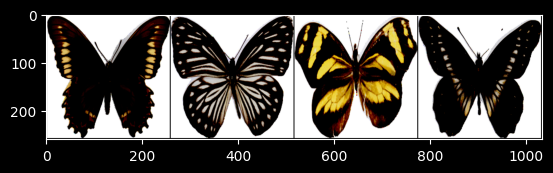

In [9]:
plt.style.use("dark_background"); # Setam dark background pentru ca e cool
print("Vizualizam un Batch:")

batch = next(iter(train_dataloader)) # Iau primul batch din dataloader
grid = torchvision.utils.make_grid(batch["images"], nrow = 4) # Creez un grid cu cele 4 imagini

plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1)); # Permut dimensiuniile adtel incat sa fie RGB si plotez imaginile

## Pas 4: Fine-Tuneing

### Pas 4.1: Definirea Parametriilor

In [10]:
epochs = 2 # Numarul de epoci de training
learning_rate = 0.001 # Learningrate-ul

device = "cuda" # Ce device folosim pentru training

scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256") # Creez un scheduler care ii da modelului inputul
scheduler.set_timesteps(num_inference_steps=40)

image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device) # Luam pipeline-ul modelului si in incarcam pe GPU
image_pipe.scheduler = scheduler # Atribuim pipeline-ului scheduler-ul definit

opt = torch.optim.Adam(image_pipe.unet.parameters(), lr = learning_rate) # Am ales Adam ca optimizer pentru ca am experienta cu acesta


diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


### Pas 4.2: Training

In [11]:
loss_logs = [] # O lista cu loss-urile obtnute pe parcursul training-ului

def train(epoch): # Functia de train/epoca

  print("Epoca: ", epoch, "/", epochs)
  print("--> Start Training")

  loss_train = 0;
  loss_valid = 0;

  total_batches = len(train_dataloader)

  # tqdm este o librarie pentru progress bars

  for pas, batch in tqdm(enumerate(train_dataloader), total = total_batches): # iteram batch-urile


    clean_images = batch["images"].to(device) # Iau imaginile originale si le incarcam pe gpu
    noise = torch.randn(clean_images.shape).to(clean_images.device) # Creez noise pe shape-ul imaginilor

    timesteps = torch.randint(
          0,
          image_pipe.scheduler.num_train_timesteps,
          (clean_images.shape[0],),
          device=clean_images.device,
      ).long() # Functia aceasta genereaza o lista de numere pentru fiecare imagine care
      # reprezinta cati pasi recurenti sa faca scheduler-ul pentru fiecare imagine

    noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps) # Adaug noise la imaginile originale
    noise_images_prediction = image_pipe.unet(clean_images, return_dict=False, timestep=timesteps) # Invocam modelul

    loss = F.mse_loss(noise_images_prediction[0], noisy_images) # Calculam loss-ul cu MSE

    opt.zero_grad()
    loss.backward(loss) # Update weight-urile modelului in functie de loss

    loss_train += loss.item() # Retimen intr-o suma loss-urile

    loss_logs.append(loss.item()) # Punem in lista de logging


  print("---> Loss Train (Suma): ", loss_train)




In [12]:
for ep in range(epochs):
  train(ep) # Chem functia de training pentru fiecare epoca
  image_pipe.save_pretrained("Finetuned_model") # Salvez modelul dupa fiecare epoca in caz ca da ceva eroare


In [13]:
# Similar ca la fine-tuning, aici incarc modelul deja trained din fisierul in care l-am salvat mai sus

PATH_scheduler = "./Finetuned_model/scheduler" # @param {type:"string"}
PATH_pipeline = "./Finetuned_model" # @param {type:"string"}

scheduler = DDIMScheduler.from_pretrained(PATH_scheduler, local_files_only = True)
image_pipe = DDPMPipeline.from_pretrained(PATH_pipeline, local_files_only = True).to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

## Pas 5: Testing

Aici voi lua un batch din dataset si voi plota imaginile rezultate.

In [14]:
batch = next(iter(train_dataloader))        # Iau primul batch de data
imagini_clean = batch["images"].to(device)  # Incarc imaginile pe gpu

# Adaug noise, similar ca in pasul de training
noise_image = torch.rand(imagini_clean.shape).to(device)
timesteps = torch.randint(
          0,
          image_pipe.scheduler.num_train_timesteps,
          (imagini_clean.shape[0],),
          device = imagini_clean.device,
      ).long()

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


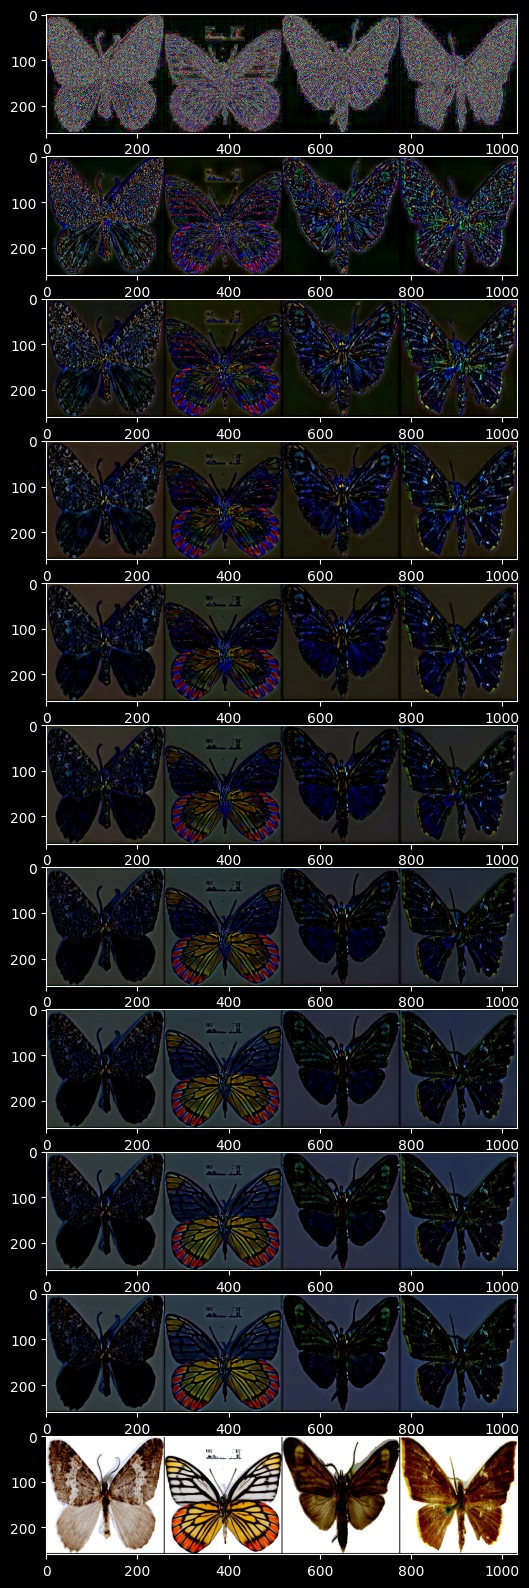

In [16]:
ax = plt.figure(figsize=(8, 20)).subplots(11, 1)

grid = torchvision.utils.make_grid(imagini_clean, nrow = 4)
ax[10].imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1));

it = 0;

for i in range(0, 1000, 100):
  timesteps_custom = torch.tensor([i, i, i, i]).to(device)
  noisy_images = image_pipe.scheduler.add_noise(imagini_clean, noise_image, timesteps_custom)

  with torch.no_grad(): # Aceasta functie spune ca modelul este in pasul de testing si
  # ca optimizer-ul sa nu incarce weight-urile pe memoria de gpu
    noise_images_prediction = image_pipe.unet(imagini_clean, return_dict = False, timestep=timesteps_custom) # Prezicem pentru noise

  # Plotam rezultatele
  grid = torchvision.utils.make_grid(noise_images_prediction[0], nrow = 4)
  ax[it].imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1));

  it += 1;

* **Obs**: Se observa ca, cum creste numarul de "pasi" prin care imagine trece prin model "calitatea" acesteia creste de asemenea.
Spre exemplu, in prima iteratie (cu o trecere a noise-ului prin model) se observa fuzz-ul pe aria fluturelui.

---

# Pas 6: Explicatii si Conclizii
---

Problema ne cere sa fine-tune un model de generare de imagini pe dataset-ul cu fluturi.

Am incarcat dataset-ul si am vazut poze cu fluturi de diferite dimensiuni. Transformariile pe care le-am aplicat au fost:
* Resize la o dimensiune standard de `256x256`
* Convertire la tensor
* Normalizare cu `mean = 0.5, std = 0.5` astfel incat fiecare pixel sa aiba o valoare intre `0, 1`.

De asemenea am folosit `torch.utils.Dataloader` pentru incarcarea datelor deoarece pot sa aplic transformarile si sa impart datele in batch-uri doar din parametrii functiei.

Pentru model am luat `google/ddpm-celebahq-256` deoarece am mai lucrat cu acest model. La training am fine-tune parametrii arhitencturii `unet`, de tip `encoder-decoder`, folosind pozele cu fluturi.  

In rezultat (Pas 5) observam ca numarul de treceri a pozei prin model influenteaza major calitatea acesteia.

## Pas 7: Imbunatatiri Ulterioare
---

* Mai multe epoci la training
* Complementarea Dataset-ului cu mai multe poze
* Un Learning Rate Scheduler astfel ca modelul sa invete mai repede in primele batch-uri